In [198]:
from numpy import *
from math import log2
from pandas import read_csv
import matplotlib.pyplot as plt

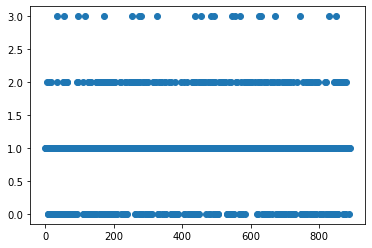

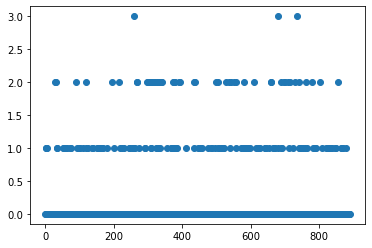

['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']
[[3, 'male', 1, 1, 0, 0, 'S', 0], [1, 'female', 1, 1, 0, 1, 'C', 1], [3, 'female', 1, 0, 0, 0, 'S', 1], [1, 'female', 1, 1, 0, 1, 'S', 1], [3, 'male', 1, 0, 0, 0, 'S', 0]]


In [199]:
def getData(filename):
    df = read_csv(filename, sep=',')
    labels = df.columns.tolist()
    labels = labels[:-1]
    dataSet = df.to_numpy()

    dataSet = [list(line) for line in dataSet]


    for i in range(len(dataSet)):
        if dataSet[i][2] <= 20:   dataSet[i][2] = 0
        elif dataSet[i][2] <= 40: dataSet[i][2] = 1
        elif dataSet[i][2] <= 60: dataSet[i][2] = 2
        else:                     dataSet[i][2] = 3

    for i in range(len(dataSet)):
        if dataSet[i][5] <= 50:    dataSet[i][5] = 0
        elif dataSet[i][5] <= 100: dataSet[i][5] = 1
        elif dataSet[i][5] <= 300: dataSet[i][5] = 2
        else:                      dataSet[i][5] = 3

    plt.scatter([i for i in range(len(dataSet))], [val[2] for val in dataSet])
    plt.show()

    plt.scatter([i for i in range(len(dataSet))], [val[5] for val in dataSet])
    plt.show()

    return dataSet, labels
        


dataSet, labels = getData('Titanic_new.csv')
print(labels, end = '\n')
print(dataSet[:5])

In [200]:
def calcEnt(dataSet):
    n = len(dataSet)
    labelCounts = {}
    for featVec in dataSet: # m 维向量，最后一维是数据类型，前m-1维是feature
        label = featVec[-1]
        if label not in labelCounts.keys():
            labelCounts[label] = 0
        labelCounts[label] += 1
    Ent = 0
    for key in labelCounts:
        p = labelCounts[key] / n
        Ent -= p * log2(p)
    return Ent

In [201]:
def split(dataSet, pos, value):
    newDataSet = []
    for featVec in dataSet:
        if featVec[pos] == value:
            tmp = featVec[:pos]
            tmp.extend(featVec[pos+1:])
            newDataSet.append(tmp)
    return newDataSet

In [202]:
def BestFeature(dataSet):
    n = len(dataSet)
    m = len(dataSet[0]) - 1
    preEnt = calcEnt(dataSet)
    maxGain = -1; bestFeature = -1
    for i in range(m):
        valueList = [sample[i] for sample in dataSet]
        uniqueValues = set(valueList)
        newEnt = 0
        for value in uniqueValues:
            subDataSet = split(dataSet, i, value)
            p = len(subDataSet) / n
            newEnt += p * calcEnt(subDataSet)
        newGain = preEnt - newEnt
        if newGain > maxGain:
            maxGain = newGain
            bestFeature = i
    return bestFeature

In [203]:
def getMainType(classList):
    classCount = {}
    for val in classList:
        if val not in classCount:
            classCount[val] = 0
        classCount[val] += 1
    sortedClassCount = sorted(classCount.items(), key=lambda x:x[1], reverse=True)
    return sortedClassCount[0][0]

In [204]:
def buildTree(dataSet, labels):
    classList = [sample[-1] for sample in dataSet] # 每一个数据的类型（结果）
    if classList.count(classList[0]) == len(dataSet): # 如果全部都是一种类型，则返回该类型
        return classList[0]
    if len(dataSet[0]) == 1: # 如果没有feature了，那么直接返回类型较多的那一个类型
        return getMainType(classList)
    bestFeature = BestFeature(dataSet) # bestFeature 是下标
    bestFeatureLabel = labels[bestFeature]
    Tree = {bestFeatureLabel:{}, "mainType":getMainType(classList)}
    valueList = [sample[bestFeature] for sample in dataSet]
    uniqueValues = set(valueList)
    for val in uniqueValues:
        subLabels = labels[:]
        del(subLabels[bestFeature])
        Tree[bestFeatureLabel][val] = buildTree(split(dataSet, bestFeature, val), subLabels)
    return Tree
Tree = buildTree(dataSet, labels)

In [205]:
# treePlotter.py是偷过来的代码来画树的样子的
#from treePlotter import *
#createPlot(Tree)
#print(Tree)

In [206]:
def predict(Tree, labels, features):
#def classify(inputTree,featLabels,testVec):
    feat = list(Tree.keys())[0]
    branch = Tree[feat]
    pos = labels.index(feat)
    key = features[pos]
    if key not in branch:
        return Tree["mainType"]
    if isinstance(branch[key], dict): 
        classLabel = predict(branch[key], labels, features)
    else: classLabel = branch[key]
    return classLabel

In [207]:
import pickle
def storeTree(Tree, filename):
    fw = open(filename, 'wb')
    pickle.dump(Tree, fw)
    fw.close()
def grabTree(filename):
    fr = open(filename, 'rb')
    return pickle.load(fr)
storeTree(Tree, 'TitanicTree')
#print(grabTree('fishTree'))

In [208]:
def Solve(filename):
    import pandas as pd
    df = read_csv(filename, sep=',')
    df['Age'].fillna(df['Age'].mean(), inplace = True)
    df['Fare'].fillna(df['Fare'].mean(), inplace = True)
    fw = df['PassengerId']
    df = df.drop(['PassengerId'], axis=1)

    labels = df.columns.tolist()
    dataSet = df.to_numpy()

    dataSet = [list(line) for line in dataSet]


    for i in range(len(dataSet)):
        if dataSet[i][2] <= 20:   dataSet[i][2] = 0
        elif dataSet[i][2] <= 40: dataSet[i][2] = 1
        elif dataSet[i][2] <= 60: dataSet[i][2] = 2
        else:                     dataSet[i][2] = 3

    for i in range(len(dataSet)):
        if dataSet[i][5] <= 50:   dataSet[i][5] = 0
        elif dataSet[i][5] <= 100: dataSet[i][5] = 1
        elif dataSet[i][5] <= 300: dataSet[i][5] = 2
        else:                     dataSet[i][5] = 3

    #plt.scatter([i for i in range(len(dataSet))], [val[2] for val in dataSet])
    #plt.show()

    #plt.scatter([i for i in range(len(dataSet))], [val[5] for val in dataSet])
    #plt.show()

    data = [[fw[i], 0] for i in range(len(fw))]
    for i in range(len(dataSet)):
        data[i][1] = predict(Tree, labels, dataSet[i])
    fw = pd.DataFrame(data, columns=['PassengerId', 'Survived'])
    fw.to_csv('submission.csv', index=False)

Solve('test.csv')